In [ ]:
import os
import json
from datetime import datetime
from typing import List, Optional
import torch
from tqdm import tqdm


def _summarize_tensor(t: torch.Tensor):
    t_cpu = t.detach().float().cpu()
    flat = t_cpu.view(-1)
    return {
        "shape": list(t_cpu.shape),
        "numel": int(flat.numel()),
        "mean": float(flat.mean().item()) if flat.numel() > 0 else 0.0,
        "std": float(flat.std(unbiased=False).item()) if flat.numel() > 1 else 0.0,
        "min": float(flat.min().item()) if flat.numel() > 0 else 0.0,
        "max": float(flat.max().item()) if flat.numel() > 0 else 0.0,
        "l2norm": float(torch.norm(flat, p=2).item()),
    }


def trainer(
    parameters: List[torch.Tensor],
    optim,
    closure,
    n_iter: int = 100,
    verbose: bool = True,
    log_json_path: Optional[str] = None,
    parameter_names: Optional[List[str]] = None,
    log_every: int = 1,
    save_full_parameters: bool = True,
):
    """
    Optimizer stepping loop with early stopping and per-iteration JSON logging.

    - parameters: list of tensors to optimize
    - optim: torch optimizer (e.g., LBFGS)
    - closure: callable that returns loss and sets gradients
    - n_iter: maximum outer iterations
    - verbose: if True, shows tqdm progress
    - log_json_path: if None, auto-creates logs/<timestamp>_<label>.jsonl
    - parameter_names: optional names (same length as parameters)
    - log_every: write one record every N iterations
    - save_full_parameters: if True, writes full parameter values; otherwise writes summaries
    """
    if parameter_names is None:
        parameter_names = [f"param_{i}" for i in range(len(parameters))]

    # Determine log destination
    if log_json_path is None:
        logs_dir = os.environ.get("TRAINER_LOG_DIR", os.path.join(os.getcwd(), "logs"))
        os.makedirs(logs_dir, exist_ok=True)
        label = "_".join(parameter_names) if parameter_names else "params"
        log_json_path = os.path.join(
            logs_dir,
            f"{datetime.utcnow().strftime('%Y%m%dT%H%M%SZ')}_trainer_{label}.jsonl",
        )
    else:
        os.makedirs(os.path.dirname(log_json_path) or ".", exist_ok=True)

    pbar = tqdm(range(n_iter)) if verbose else range(n_iter)
    previous_parameters = None
    previous_loss = None

    for iteration in pbar:
        if iteration > 0:
            previous_parameters = [p.clone() for p in parameters]
            previous_loss = loss.clone() if 'loss' in locals() else None

        loss = optim.step(closure)

        # Compute deltas and grad norm for early stopping and logging
        if iteration > 0 and previous_parameters is not None and previous_loss is not None:
            d_loss = (previous_loss - loss).item()
            d_parameters = sum(
                torch.norm(prev - curr, p=2).item()
                for prev, curr in zip(previous_parameters, parameters)
            )
        else:
            d_loss = None
            d_parameters = None

        grad_norm = sum(
            torch.norm(p.grad, p=2).item() for p in parameters if getattr(p, "grad", None) is not None
        )

        # Logging
        if (iteration % log_every) == 0:
            record = {
                "iteration": int(iteration),
                "loss": float(loss.item()),
                "grad_norm": float(grad_norm),
            }

            if d_loss is not None:
                record["d_loss"] = float(d_loss)
            if d_parameters is not None:
                record["d_parameters"] = float(d_parameters)

            if save_full_parameters:
                record["parameters"] = {
                    name: p.detach().float().cpu().tolist() for name, p in zip(parameter_names, parameters)
                }
            else:
                record["parameter_summary"] = {
                    name: _summarize_tensor(p) for name, p in zip(parameter_names, parameters)
                }

            with open(log_json_path, "a") as fp:
                fp.write(json.dumps(record) + "\n")

        if verbose and isinstance(pbar, tqdm):
            pbar.set_postfix(
                {
                    "grad_norm": grad_norm,
                    "d_param": d_parameters if d_parameters is not None else 0.0,
                    "d_loss": d_loss if d_loss is not None else 0.0,
                    "loss": float(loss.item()),
                }
            )

        # Early stopping
        if (
            d_loss is not None
            and d_parameters is not None
            and abs(d_loss) < 1e-5
            and d_parameters < 1e-5
            and grad_norm < 1e-5
        ):
            break

    return parameters



# Define functions

In [ ]:
import pandas as pd
import numpy as np
import torch
import pickle
import os
import json
import gc
from torch.distributions import Bernoulli
from torch.optim import LBFGS
from tqdm import tqdm
from scipy.stats import pearsonr
from collections import defaultdict
from concurrent.futures import ProcessPoolExecutor
from multiprocessing import Manager
import multiprocessing as mp

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tueplots import bundles
bundles.icml2024()

from torchmetrics import AUROC
auroc = AUROC(task="binary")

import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(0)

device = "cuda:0"

def visualize_response_matrix(results, value, filename):
    # Extract the groups labels in the order of the columns
    group_values = results.columns.get_level_values("scenario")

    # Identify the boundaries where the group changes
    boundaries = []
    for i in range(1, len(group_values)):
        if group_values[i] != group_values[i - 1]:
            boundaries.append(i - 0.5)  # using 0.5 to place the line between columns

    # Visualize the results with a matrix: red is 0, white is -1 and blue is 1
    cmap = mcolors.ListedColormap(["white", "red", "blue"])
    bounds = [-1.5, -0.5, 0.5, 1.5]
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    # Calculate midpoints for each group label
    groups_list = list(group_values)
    group_names = []
    group_midpoints = []
    current_group = groups_list[0]
    start_index = 0
    for i, grp in enumerate(groups_list):
        if grp != current_group:
            midpoint = (start_index + i - 1) / 2.0
            group_names.append(current_group)
            group_midpoints.append(midpoint)
            current_group = grp
            start_index = i
    # Add the last group
    midpoint = (start_index + len(groups_list) - 1) / 2.0
    group_names.append(current_group)
    group_midpoints.append(midpoint)

    # Define the minimum spacing between labels (e.g., 100 units)
    min_spacing = 100
    last_label_pos = -float("inf")
    # Plot the matrix
    with plt.rc_context(bundles.icml2024(usetex=True, family="serif")):
        fig, ax = plt.subplots(figsize=(20, 10))
        cax = ax.matshow(value, aspect="auto", cmap=cmap, norm=norm)

        # Add vertical lines at each boundary
        for b in boundaries:
            ax.axvline(x=b, color="black", linewidth=0.25, linestyle="--", alpha=0.5)
        
        # Add group labels above the matrix, only if they're spaced enough apart
        for name, pos in zip(group_names, group_midpoints):
            if pos - last_label_pos >= min_spacing:
                ax.text(pos, -5, name, ha='center', va='bottom', rotation=90, fontsize=3)
                last_label_pos = pos

        # Add model labels on the y-axis
        ax.set_yticks(range(len(results.index)))
        ax.set_yticklabels(results.index, fontsize=3)

        # Add a colorbar
        cbar = plt.colorbar(cax)
        cbar.set_ticks([-1, 0, 1])
        cbar.set_ticklabels(["-1", "0", "1"])
        plt.savefig(filename, dpi=600, bbox_inches="tight")
        plt.close()

def trainer(parameters, optim, closure, n_iter=100, verbose=True):
    pbar = tqdm(range(n_iter)) if verbose else range(n_iter)
    for iteration in pbar:
        if iteration > 0:
            previous_parameters = [p.clone() for p in parameters]
            previous_loss = loss.clone()
        
        loss = optim.step(closure)
        
        if iteration > 0:
            d_loss = (previous_loss - loss).item()
            d_parameters = sum(
                torch.norm(prev - curr, p=2).item()
                for prev, curr in zip(previous_parameters, parameters)
            )
            grad_norm = sum(torch.norm(p.grad, p=2).item() for p in parameters if p.grad is not None)
            if verbose:
                pbar.set_postfix({"grad_norm": grad_norm, "d_parameter": d_parameters, "d_loss": d_loss})
            
            if d_loss < 1e-5 and d_parameters < 1e-5 and grad_norm < 1e-5:
                break
    return parameters

def compute_auc(probs, data, train_idtor, test_idtor):
    train_probs = probs[train_idtor.bool()]
    test_probs = probs[test_idtor.bool()]
    train_labels = data[train_idtor.bool()]
    test_labels = data[test_idtor.bool()]
    
    train_auc = auroc(train_probs, train_labels)
    test_auc = auroc(test_probs, test_labels)
    print(f"train auc: {train_auc}")
    print(f"test auc: {test_auc}")
    
    return train_auc, test_auc

def compute_cttcorr(probs, data, train_idtor, test_idtor):
    train_probs  = probs.clone()
    test_probs   = probs.clone()
    train_labels = data.clone()
    test_labels  = data.clone()

    train_mask = ~train_idtor.bool()
    train_probs[train_mask]  = float('nan')
    train_labels[train_mask] = float('nan')

    test_mask = ~test_idtor.bool()
    test_probs[test_mask]   = float('nan')
    test_labels[test_mask]  = float('nan')
    
    train_prob_ctt = torch.nanmean(train_probs, dim=1).detach().cpu().numpy()
    train_label_ctt = torch.nanmean(train_labels, dim=1).detach().cpu().numpy()
    train_mask = ~np.isnan(train_prob_ctt) & ~np.isnan(train_label_ctt)
    train_cttcorr = pearsonr(train_prob_ctt[train_mask], train_label_ctt[train_mask]).statistic
    
    test_prob_ctt = torch.nanmean(test_probs, dim=1).detach().cpu().numpy()
    test_label_ctt = torch.nanmean(test_labels, dim=1).detach().cpu().numpy()
    test_mask = ~np.isnan(test_prob_ctt) & ~np.isnan(test_label_ctt)
    test_cttcorr = pearsonr(test_prob_ctt[test_mask], test_label_ctt[test_mask]).statistic
    
    print(f"train cttcorr: {train_cttcorr}")
    print(f"test cttcorr: {test_cttcorr}")

    return train_cttcorr, test_cttcorr

In [ ]:
# Override trainer with JSON logging after original definitions
import os
import json
from datetime import datetime
from typing import List, Optional
import torch
from tqdm import tqdm


def _summarize_tensor(t: torch.Tensor):
    t_cpu = t.detach().float().cpu()
    flat = t_cpu.view(-1)
    return {
        "shape": list(t_cpu.shape),
        "numel": int(flat.numel()),
        "mean": float(flat.mean().item()) if flat.numel() > 0 else 0.0,
        "std": float(flat.std(unbiased=False).item()) if flat.numel() > 1 else 0.0,
        "min": float(flat.min().item()) if flat.numel() > 0 else 0.0,
        "max": float(flat.max().item()) if flat.numel() > 0 else 0.0,
        "l2norm": float(torch.norm(flat, p=2).item()),
    }


def trainer(
    parameters: List[torch.Tensor],
    optim,
    closure,
    n_iter: int = 100,
    verbose: bool = True,
    log_json_path: Optional[str] = None,
    parameter_names: Optional[List[str]] = None,
    log_every: int = 1,
    save_full_parameters: bool = True,
):
    if parameter_names is None:
        parameter_names = [f"param_{i}" for i in range(len(parameters))]

    if log_json_path is None:
        logs_dir = os.environ.get("TRAINER_LOG_DIR", os.path.join(os.getcwd(), "logs"))
        os.makedirs(logs_dir, exist_ok=True)
        label = "_".join(parameter_names) if parameter_names else "params"
        log_json_path = os.path.join(
            logs_dir,
            f"{datetime.utcnow().strftime('%Y%m%dT%H%M%SZ')}_trainer_{label}.jsonl",
        )
    else:
        os.makedirs(os.path.dirname(log_json_path) or ".", exist_ok=True)

    pbar = tqdm(range(n_iter)) if verbose else range(n_iter)
    previous_parameters = None
    previous_loss = None

    for iteration in pbar:
        if iteration > 0:
            previous_parameters = [p.clone() for p in parameters]
            previous_loss = loss.clone() if 'loss' in locals() else None

        loss = optim.step(closure)

        if iteration > 0 and previous_parameters is not None and previous_loss is not None:
            d_loss = (previous_loss - loss).item()
            d_parameters = sum(
                torch.norm(prev - curr, p=2).item()
                for prev, curr in zip(previous_parameters, parameters)
            )
        else:
            d_loss = None
            d_parameters = None

        grad_norm = sum(
            torch.norm(p.grad, p=2).item() for p in parameters if getattr(p, "grad", None) is not None
        )

        if (iteration % log_every) == 0:
            record = {
                "iteration": int(iteration),
                "loss": float(loss.item()),
                "grad_norm": float(grad_norm),
            }
            if d_loss is not None:
                record["d_loss"] = float(d_loss)
            if d_parameters is not None:
                record["d_parameters"] = float(d_parameters)

            if save_full_parameters:
                record["parameters"] = {
                    name: p.detach().float().cpu().tolist() for name, p in zip(parameter_names, parameters)
                }
            else:
                record["parameter_summary"] = {
                    name: _summarize_tensor(p) for name, p in zip(parameter_names, parameters)
                }

            with open(log_json_path, "a") as fp:
                fp.write(json.dumps(record) + "\n")

        if verbose and isinstance(pbar, tqdm):
            pbar.set_postfix(
                {
                    "grad_norm": grad_norm,
                    "d_param": d_parameters if d_parameters is not None else 0.0,
                    "d_loss": d_loss if d_loss is not None else 0.0,
                    "loss": float(loss.item()),
                }
            )

        if (
            d_loss is not None
            and d_parameters is not None
            and abs(d_loss) < 1e-5
            and d_parameters < 1e-5
            and grad_norm < 1e-5
        ):
            break

    return parameters



# Load data

In [5]:
with open(f"../data/resmat.pkl", "rb") as f:
    results = pickle.load(f)
    
# data_withnan, missing=nan
# data_withneg1, missing=-1
# data_with0, missing=0
data_withnan = torch.tensor(results.values, dtype=torch.float, device=device)
data_withneg1 = data_withnan.nan_to_num(nan=-1.0)
data_idtor = (data_withneg1 != -1).to(float)
data_with0 = data_withneg1 * data_idtor # -1 -> 0
n_test_takers, n_items = data_with0.shape
scenarios = results.columns.get_level_values("scenario").unique()

# save dict
metric_results = defaultdict(dict)

# Data stats

In [4]:
vis_resmat_dir = "../result/visualize_resmat"
os.makedirs(vis_resmat_dir, exist_ok=True)

# overall stats
print("Number of test takers:", results.shape[0])
print("Number of items:", results.shape[1])
print("Number of scenarios:", results.columns.get_level_values("scenario").nunique())
visualize_response_matrix(results, results, f"{vis_resmat_dir}/resmat_all")

# count the number of items and test takers in each dataset
scenario_counts = {}
for scenario in sorted(scenarios):
    mask = results.columns.get_level_values("scenario") == scenario
    sub_results = results.loc[:, mask]
    scenario_counts[scenario] = {
        "n_items": sub_results.shape[1],
        "n_test_takers": sub_results.notna().any(axis=1).sum()
    }
    print(f"{scenario}: {scenario_counts[scenario]['n_test_takers']} test takers, {scenario_counts[scenario]['n_items']} items")
    # visualize_response_matrix(sub_results, sub_results, f"{vis_resmat_dir}/resmat_{scenario}")

Number of test takers: 183
Number of items: 78712
Number of scenarios: 22
air_bench_2024: 41 test takers, 4985 items
babi_qa: 70 test takers, 3461 items
bbq: 42 test takers, 999 items
boolq: 67 test takers, 3316 items
civil_comments: 67 test takers, 29407 items
commonsense: 91 test takers, 498 items
dyck_language_np=3: 69 test takers, 500 items
entity_data_imputation: 67 test takers, 395 items
entity_matching: 67 test takers, 1396 items
gsm: 90 test takers, 997 items
imdb: 67 test takers, 3530 items
legal_support: 69 test takers, 594 items
legalbench: 91 test takers, 1997 items
lsat_qa: 69 test takers, 454 items
math: 91 test takers, 436 items
med_qa: 91 test takers, 998 items
mmlu: 79 test takers, 13223 items
raft: 67 test takers, 1336 items
synthetic_reasoning: 69 test takers, 2234 items
thai_exam: 40 test takers, 557 items
truthful_qa: 67 test takers, 1888 items
wikifact: 67 test takers, 5511 items


# Naive prediction

In [5]:
# overall mean
naive_prediction_0 = torch.nanmean(data_withnan)
naive_prediction_0 = naive_prediction_0.expand(data_withnan.shape[0], data_withnan.shape[1])
auc_train_0 = auroc(naive_prediction_0[data_idtor.bool()], data_withnan[data_idtor.bool()]).item()
print(f"Naive auc 0: {auc_train_0}")

# question difficulty average
naive_prediction_1 = torch.nanmean(data_withnan, dim=0)
naive_prediction_1 = naive_prediction_1[None, :].expand(data_withnan.shape[0], data_withnan.shape[1])
auc_train_1_1 = auroc(naive_prediction_1[data_idtor.bool()], data_withnan[data_idtor.bool()]).item()
print(f"Naive auc 1.1: {auc_train_1_1}")

# test taker average
naive_prediction_1 = torch.nanmean(data_withnan, dim=1)
naive_prediction_1 = naive_prediction_1[:, None].expand(data_withnan.shape[0], data_withnan.shape[1])
auc_train_1_2 = auroc(naive_prediction_1[data_idtor.bool()], data_withnan[data_idtor.bool()]).item()
print(f"Naive auc 1.2: {auc_train_1_2}")

Naive auc 0: 0.5
Naive auc 1.1: 0.8070003986358643
Naive auc 1.2: 0.6573556065559387


# Simple Rasch model

fit one theta for all datasets

In [ ]:
valid_condition = False
trial = 0 
# If a test-taker or an item has no data in the training set, the model has no information to learn their ability
# or difficulty. The while loop keeps trying new random splits until this crucial condition is met,
# preventing errors during training.
# Valid split means every person has at least 1 train item AND every item has at least 1 train response
while not valid_condition:
    # Create random binary mask: 80% chance each observed data point goes to training
    # This is the authors' train-test splitting method
    train_idtor = torch.bernoulli(data_idtor * 0.8).int()
    test_idtor = data_idtor - train_idtor
    valid_condition = (train_idtor.sum(axis=1) != 0).all() and (train_idtor.sum(axis=0) != 0).all()
    print(f"trial {trial} valid condition: {valid_condition}")
    trial += 1

# Fit item difficulties (z parameters) in batch
B = 50000
optimized_zs = []
# Initialising 150 thetas of dimension of n_test_takers with random values
# This is to perform Monte Carlo simulation for unknown random theta
thetas_nuisance = torch.randn(150, n_test_takers, device=device)

# For each batched items, we fix thetas with random variables then optimise z for each question following LBFGS
for i in tqdm(range(0, n_items, B)):    # Loop through items in chunks of size B
    data_batch = data_with0[:, i:i+B]   # Get current batch of item responses
    train_idtor_batch = train_idtor[:, i:i+B]   # Get training mask for current batch
    current_B = data_batch.shape[1] # Actual batch size (last batch might be smaller)
    
    # Initialize item difficulties for this batch randomly
    z_i = torch.randn(current_B, requires_grad=True, device=device)
    # Set up L-BFGS optimizer for this batch of item difficulties
    optim_z_i = LBFGS([z_i], lr=0.1, max_iter=20, history_size=10, line_search_fn="strong_wolfe")
    
    def closure_z_i():  # Closure function required by L-BFGS
        optim_z_i.zero_grad()
        probs = torch.sigmoid(thetas_nuisance[:, :, None] + z_i[None, None, :])
        # Compute negative log-likelihood loss (only on training data)
        # train_idtor is 0 for test items, this is to mask away the test items and keep only training data
        # for log_prob, each data entry that is incorrect is 0, and is calculated as log(1-p). Whereas, correct ones are log(p)
        # p is the bernoulli probability with the given distribution (for each item, and each dimension)
        # averaging out the loss over 150 samples to finish Monte-Carlo simulation
        loss = -(Bernoulli(probs=probs).log_prob(data_batch)*train_idtor_batch).mean()
        # Compute gradients, by back-propagating all the previous elements (each item in each dimension)
        # inside the tensor (zs, this happens automatically cuz PyTorch is GOAT)
        loss.backward()
        return loss
    z_i_optimized = trainer([z_i], optim_z_i, closure_z_i, parameter_names=["z"], log_json_path=os.path.join("../result/logs", f"rasch_global_z_batch_{i}_{i+current_B}.jsonl"))[0].detach()
    optimized_zs.append(z_i_optimized)  # Store optimized difficulties

zs = torch.cat(optimized_zs)

# Fit person abilities (theta parameters) using all items with fixed difficulties
thetas = torch.randn(n_test_takers, requires_grad=True, device=device)  # Initialize abilities randomly
# Set up L-BFGS optimizer for person abilities
optim_theta = LBFGS([thetas], lr=0.1, max_iter=20, history_size=10, line_search_fn="strong_wolfe")

def closure_theta():  # Closure function for optimizing abilities same as difficulties (closure_z_i)
    optim_theta.zero_grad()  # Clear gradients
    # Compute probabilities using estimated abilities and fixed item difficulties
    probs = torch.sigmoid(thetas[:, None] + zs[None, :])
    loss = -(Bernoulli(probs=probs).log_prob(data_with0)*train_idtor).mean()
    loss.backward()
    return loss

thetas = trainer([thetas], optim_theta, closure_theta, parameter_names=["theta"], log_json_path=os.path.join("../result/logs", "rasch_global_theta.jsonl"))[0]

# Calculate final model predictions using optimized parameters
probs = torch.sigmoid(thetas[:, None] + zs[None, :])  # P(correct) = sigmoid(ability + difficulty)

# Evaluate model performance using AUC (Area Under ROC Curve)
train_auc, test_auc = compute_auc(probs, data_with0, train_idtor, test_idtor)
metric_results["combined_data"]["train_auc"] = train_auc.item()  # Store training AUC
metric_results["combined_data"]["test_auc"] = test_auc.item()   # Store test AUC

# Evaluate model performance using CTT correlation (Classical Test Theory)
train_cttcorr, test_cttcorr = compute_cttcorr(probs, data_with0, train_idtor, test_idtor)
metric_results["combined_data"]["train_cttcorr"] = train_cttcorr.item()  # Store training correlation
metric_results["combined_data"]["test_cttcorr"] = test_cttcorr.item()   # Store test correlation

# Clean up memory by deleting large objects and clearing GPU cache
del optim_theta, thetas, z_i, thetas_nuisance, optim_z_i
gc.collect()  # Force garbage collection
torch.cuda.empty_cache()  # Clear GPU memory cache

trial 0 valid condition: True


  0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            | 0/2 [00:00<?, ?it/s]

 13%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       | 13/100 [00:00<00:04, 19.32it/s, grad_norm=2.21e-7, d_parameter=0, d_loss=8.76e-11]


train auc: 0.8402137756347656
test auc: 0.8265656232833862
train cttcorr: 0.999998942784063
test cttcorr: 0.9927187362960916


# Rasch

fit one theta for each dataset

reuses z from before

In [ ]:
# Rasch per-scenario calibration: reuse globally estimated item difficulties (zs)
# and re-estimate person abilities (theta) separately for each scenario subset.
calres_dir = "../data/calibration_result"            # Directory to store calibration outputs
os.makedirs(calres_dir, exist_ok=True)                 # Create directory if it doesn't exist (no error if it does)

for scenario in scenarios:                             # Iterate over each scenario (dataset / item subset)
    print(f"\n{scenario}")
    mask = (results.columns.get_level_values("scenario") == scenario)   # Boolean mask selecting this scenario's columns
    data_scenario = data_with0[:, mask]                # Responses (persons × items_in_scenario), missing already 0
    train_idtor_scenario = train_idtor[:, mask]        # Train indicator restricted to scenario items
    test_idtor_scenario  = test_idtor[:, mask]         # Test indicator restricted likewise
    z_scenario = zs[mask]                              # Item difficulty parameters for this scenario (taken from global fit)

    # Save item difficulties for traceability / later analysis
    df_z = pd.DataFrame({"z": z_scenario.detach().cpu().numpy()})
    df_z.to_csv(f'{calres_dir}/z_{scenario}.csv', index=False)

    # Initialize person abilities (theta) at zero (identifiability: Rasch shift absorbed in z already)
    thetas = torch.zeros(n_test_takers, requires_grad=True, device=device)
    # L-BFGS optimizer (quasi-Newton) usually converges faster for small parameter vectors
    optim_theta = torch.optim.LBFGS(
        [thetas], lr=0.1, max_iter=20, history_size=10, line_search_fn="strong_wolfe"
    )

    def closure_theta():                               # Closure required by LBFGS to recompute loss & gradients
        optim_theta.zero_grad()                        # Clear previous gradients
        probs = torch.sigmoid(thetas[:, None] + z_scenario[None, :])   # Rasch: P_ij = sigmoid(theta_i + z_j)
        # Negative log-likelihood over Bernoulli responses, masking to training cells only
        # (data_scenario ∈ {0,1}; train_idtor_scenario zeros out non-train cells)
        loss = -(Bernoulli(probs=probs).log_prob(data_scenario) * train_idtor_scenario).mean()
        loss.backward()                                # Backprop to compute gradients w.r.t thetas
        return loss

    # Optimize theta parameters (trainer wraps repeated optimizer.step calls + early stopping)
    thetas = trainer([thetas], optim_theta, closure_theta, verbose=False, parameter_names=["theta"], log_json_path=os.path.join("../result/logs", f"rasch_scenario_{scenario}_theta.jsonl"))[0]

    # Materialize and save non-trivial (non-zero) theta estimates.
    # Zero values usually correspond to persons with no training responses in this scenario.
    df_theta = pd.DataFrame({"theta": thetas.detach().cpu().numpy()})
    df_theta = df_theta[df_theta["theta"] != 0]       # Filter out untouched thetas (optional heuristic)
    df_theta.to_csv(f'{calres_dir}/theta_{scenario}.csv', index=False)

    # Recompute probabilities with fitted thetas for evaluation
    probs = torch.sigmoid(thetas[:, None] + z_scenario[None, :])

    # AUC on train and test partitions
    train_auc, test_auc = compute_auc(probs, data_scenario, train_idtor_scenario, test_idtor_scenario)
    metric_results[scenario]["train_auc"] = train_auc.item()
    metric_results[scenario]["test_auc"]  = test_auc.item()
    
    # Classical Test Theory style correlation (mean predicted vs mean observed per person)
    train_cttcorr, test_cttcorr = compute_cttcorr(probs, data_scenario, train_idtor_scenario, test_idtor_scenario)
    metric_results[scenario]["train_cttcorr"] = train_cttcorr.item()
    metric_results[scenario]["test_cttcorr"]  = test_cttcorr.item()

# Free large tensors / optimizer objects to release memory (especially GPU)
del zs, optim_theta, thetas
gc.collect()
torch.cuda.empty_cache()


lsat_qa
train auc: 0.6885020732879639
test auc: 0.6195417642593384
train cttcorr: 0.9999999972999117
test cttcorr: 0.5914744119124559

truthful_qa
train auc: 0.7754521369934082
test auc: 0.7521977424621582
train cttcorr: 0.9999999890975424
test cttcorr: 0.9705701018338492

synthetic_reasoning
train auc: 0.8787851929664612
test auc: 0.8684341311454773
train cttcorr: 0.9999999998367093
test cttcorr: 0.9944160113974599

babi_qa
train auc: 0.8385903239250183
test auc: 0.82568359375
train cttcorr: 0.9999999978926333
test cttcorr: 0.9801552224953756

wikifact
train auc: 0.8949174880981445
test auc: 0.8831348419189453
train cttcorr: 0.999999998540401
test cttcorr: 0.9955537306021037

bbq
train auc: 0.7258046865463257
test auc: 0.6775155067443848
train cttcorr: 0.9999999966710638
test cttcorr: 0.9851155507875281

thai_exam
train auc: 0.857990562915802
test auc: 0.8283470273017883
train cttcorr: 0.99999999333132
test cttcorr: 0.9472261461296729

dyck_language_np=3
train auc: 0.7988154888153076

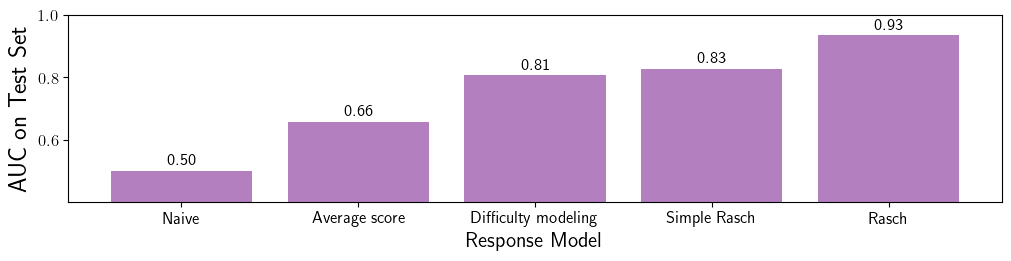

In [8]:
values = [
    auc_train_0, auc_train_1_2, auc_train_1_1, 
    metric_results["combined_data"]["test_auc"],
    np.max(np.array([metric_results[scenario]["test_auc"] for scenario in scenarios]))
]
# Difficulty modeling is the approximation of zs, the first stage of Simple Rasch
labels = ['Naive', 'Average score', 'Difficulty modeling', 'Simple Rasch', 'Rasch']

with plt.rc_context(bundles.icml2024(usetex=True, family="serif")):
    fig, ax = plt.subplots(figsize=(10, 2.5))
    bars = ax.bar(labels, values, color='#b37fbf')

    ax.set_xlabel(r'Response Model', fontsize=15)
    ax.set_ylabel(r'AUC on Test Set', fontsize=18)
    ax.set_ylim(0.4, 1.0)
    ax.set_yticks([i/5 for i in range(3, 6)])
    plt.tick_params(axis="both", labelsize=12)

    for bar, v in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width() / 2, v + 0.01, f'{v:.2f}', 
                ha='center', va='bottom', fontsize=12)
    
    plt.savefig("../result/test_auc_grow.png", dpi=300, bbox_inches="tight")
plt.show()

# Amortized Difficulty

In [ ]:
# Check file gather_helm_data/embed.py for the embedding generation
with open(f"../data/embed_meta-llama_Llama-3.1-8B-Instruct.pkl", "rb") as f:
    df_embed = pickle.load(f)
question_to_emb = dict(zip(df_embed["question"], df_embed["embedding"]))
questions = results.columns.get_level_values("input.text").tolist()
embeds = [question_to_emb.get(q, None) for q in questions]
embed_dim = len(next(item for item in embeds if item is not None))
print(f"embed_dim: {embed_dim}")

embed_dim: 4096


In [ ]:
# Amortized Difficulty: fit item difficulties as a function of item embeddings (if available)
# and free parameter otherwise, for each scenario and for the combined data.
all_scenarios = results.columns.get_level_values("scenario").unique().tolist() + ["combined_data"]
# combined_data is for global simple rasch model

for scenario in all_scenarios:
    print(f"\n{scenario}")
    if scenario != "combined_data":
        # Select only items belonging to this scenario
        mask = (results.columns.get_level_values("scenario") == scenario)
        data_scenario = data_with0[:, mask]
        data_idtor_scenario = data_idtor[:, mask]
        embeds_scenario = [emb for emb, m in zip(embeds, mask) if m]
    else:
        # Use all items for combined data
        data_scenario = data_with0
        data_idtor_scenario = data_idtor
        test_idtor_scenario = test_idtor
        embeds_scenario = embeds
    n_items_scenario = data_scenario.shape[1]
    
    # Identify which items have embedding features
    has_feature = [0.0 if item is None else 1.0 for item in embeds_scenario]
    has_feature = torch.tensor(has_feature, dtype=torch.float, device=device)
    # Randomly assign 80% of items with features to train, rest to test
    has_feature_train = torch.bernoulli(has_feature * 0.8).int()
    has_feature_test = (has_feature - has_feature_train).int()

    # Build feature matrix: zero vector for items without embedding, embedding vector otherwise
    features = [[0] * embed_dim if i is None else i for i in embeds_scenario]
    features = torch.tensor(features, dtype=torch.float, device=device)
    # Build train/test indicator matrices for scenario
    train_idtor_scenario = has_feature_train[None, :].repeat(n_test_takers, 1) * data_idtor_scenario
    test_idtor_scenario = has_feature_test[None, :].repeat(n_test_takers, 1) * data_idtor_scenario
    
    B = 50000  # Batch size for optimization
    thetas_nuisance = torch.randn(150, n_test_takers, device=device)  # Nuisance thetas for marginalization
    w = torch.randn(embed_dim, requires_grad=True, device=device)      # Linear weights for embedding
    b = torch.randn(1, requires_grad=True, device=device)              # Bias for embedding
    z_free = torch.zeros(n_items_scenario, requires_grad=True, device=device)  # Free item difficulties for items w/o embedding
    optim_z = LBFGS([z_free, w, b], lr=0.1, max_iter=20, history_size=10, line_search_fn="strong_wolfe")
    
    def closure_z():
        # Randomly sample a batch of items for optimization
        idx = torch.randperm(n_items_scenario)[:B]
        data_batch = data_scenario[:, idx]
        train_idtor_batch = train_idtor_scenario[:, idx]
        features_batch = features[idx]
        has_feature_train_batch = has_feature_train[idx]
        z_free_batch = z_free[idx]
        
        optim_z.zero_grad()
        # For items with embedding: z = features@w + b; else: z = z_free
        z = z_free_batch * (1 - has_feature_train_batch) + (features_batch@w + b) * has_feature_train_batch
        probs = torch.sigmoid(thetas_nuisance[:, :, None] + z[None, None, :])
        loss = -(Bernoulli(probs=probs).log_prob(data_batch)*train_idtor_batch).mean()
        loss.backward()
        return loss
    
    # Optimize item difficulties (z) and embedding weights (w, b)
    z_free, w, b = trainer(
        [z_free, w, b],
        optim_z,
        closure_z,
        parameter_names=["z_free", "w", "b"],
        log_json_path=os.path.join("../result/logs", f"amortized_{scenario}_z_w_b.jsonl")
    )
    # Compute final item difficulties for all items
    z = z_free * (1 - has_feature) + (features@w + b) * has_feature
    z = z.detach()

    # Fit person abilities (theta) for this scenario
    thetas = torch.randn(n_test_takers, requires_grad=True, device=device)
    optim_theta = LBFGS([thetas], lr=0.1, max_iter=20, history_size=10, line_search_fn="strong_wolfe")
    def closure_theta():
        optim_theta.zero_grad()
        probs = torch.sigmoid(thetas[:, None] + z[None, :])
        loss = -(Bernoulli(probs=probs).log_prob(data_scenario)*train_idtor_scenario).mean()
        loss.backward()
        return loss
    thetas = trainer([thetas], optim_theta, closure_theta, parameter_names=["theta"], log_json_path=os.path.join("../result/logs", f"amortized_{scenario}_theta.jsonl"))[0]

    # Compute predicted probabilities
    probs = torch.sigmoid(thetas[:, None] + z[None, :])
    
    # Evaluate AUC on train and test sets
    train_auc, test_auc = compute_auc(probs, data_scenario, train_idtor_scenario, test_idtor_scenario)
    metric_results[scenario]["amortized_train_auc"] = train_auc.item()
    metric_results[scenario]["amortized_test_auc"] = test_auc.item()

    # Evaluate CTT correlation on train and test sets
    train_cttcorr, test_cttcorr = compute_cttcorr(probs, data_scenario, train_idtor_scenario, test_idtor_scenario)
    metric_results[scenario]["amortized_train_cttcorr"] = train_cttcorr.item()
    metric_results[scenario]["amortized_test_cttcorr"] = test_cttcorr.item()
    
    gc.collect()
    torch.cuda.empty_cache()


lsat_qa


  7%|███████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                | 7/100 [00:00<00:02, 34.54it/s, grad_norm=2.37e-7, d_parameter=0, d_loss=4.16e-9]


train auc: 0.6763260364532471
test auc: 0.533271074295044
train cttcorr: 0.9999999855571661
test cttcorr: 0.6666514225457503

truthful_qa


 12%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                | 12/100 [00:00<00:00, 107.07it/s, grad_norm=5.75e-7, d_parameter=0, d_loss=1.65e-10]


train auc: 0.7722413539886475
test auc: 0.7296116948127747
train cttcorr: 0.9999999899322035
test cttcorr: 0.9830719203367174

synthetic_reasoning


  8%|████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       | 8/100 [00:00<00:01, 52.06it/s, grad_norm=2.49e-7, d_parameter=0, d_loss=2.08e-9]


train auc: 0.8777711391448975
test auc: 0.7192123532295227
train cttcorr: 0.9999999991950111
test cttcorr: 0.9937904613333027

babi_qa


  6%|██████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         | 6/100 [00:00<00:03, 30.88it/s, grad_norm=1.89e-7, d_parameter=0, d_loss=3.59e-9]


train auc: 0.8309568166732788
test auc: 0.7370664477348328
train cttcorr: 0.9999999981787767
test cttcorr: 0.9827419597534225

wikifact


 11%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 11/100 [00:00<00:00, 90.50it/s, grad_norm=2.17e-7, d_parameter=0, d_loss=1.03e-10]


train auc: 0.8895800113677979
test auc: 0.653024435043335
train cttcorr: 0.999999998868991
test cttcorr: 0.9921132490586263

bbq


 12%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                | 12/100 [00:00<00:01, 80.35it/s, grad_norm=5.58e-7, d_parameter=0, d_loss=-1.53e-11]


train auc: 0.7185817956924438
test auc: 0.6290475130081177
train cttcorr: 0.9999999936946713
test cttcorr: 0.9826839304952918

thai_exam


  2%|██████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              | 2/100 [00:00<00:02, 34.71it/s, grad_norm=6.3e-7, d_parameter=0, d_loss=1.95e-9]


train auc: 0.8551082015037537
test auc: 0.6553918719291687
train cttcorr: 0.9999999909008068
test cttcorr: 0.9563553001283531

dyck_language_np=3


 12%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                | 12/100 [00:00<00:01, 59.19it/s, grad_norm=2.45e-7, d_parameter=0, d_loss=9.83e-11]


train auc: 0.7979531288146973
test auc: 0.7311034202575684
train cttcorr: 0.9999999994393965
test cttcorr: 0.9252554053045023

legal_support


 10%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    | 10/100 [00:00<00:02, 39.25it/s, grad_norm=2.49e-7, d_parameter=0, d_loss=2.12e-9]


train auc: 0.7111147046089172
test auc: 0.5263113975524902
train cttcorr: 0.9999999978016798
test cttcorr: 0.8984408634834505

civil_comments


 12%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                | 12/100 [00:00<00:01, 54.50it/s, grad_norm=4.36e-7, d_parameter=0, d_loss=9.96e-11]


train auc: 0.759771466255188
test auc: 0.7547475099563599
train cttcorr: 0.9999999980620158
test cttcorr: 0.9996480558965548

legalbench

legalbench


  4%|████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | 4/100 [00:00<00:01, 59.04it/s, grad_norm=3.91e-7, d_parameter=0, d_loss=6.47e-10]


train auc: 0.84792560338974
test auc: 0.6275990009307861
train cttcorr: 0.9999999946757762
test cttcorr: 0.9735571779462975

raft

raft


  7%|███████████████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              | 7/100 [00:00<00:01, 82.47it/s, grad_norm=6.92e-7, d_parameter=0, d_loss=-1.01e-11]


train auc: 0.8404725790023804
test auc: 0.8156154751777649
train cttcorr: 0.9999999883784033
test cttcorr: 0.9724920697462726

air_bench_2024

air_bench_2024


  3%|███████████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    | 3/100 [00:00<00:01, 56.56it/s, grad_norm=4.03e-7, d_parameter=0, d_loss=6.3e-10]


train auc: 0.9156495928764343
test auc: 0.737615704536438
train cttcorr: 0.9999999972975504
test cttcorr: 0.9957386983790383

math

math


 10%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  | 10/100 [00:00<00:01, 73.72it/s, grad_norm=4.24e-7, d_parameter=0, d_loss=-1.22e-10]


train auc: 0.906830906867981
test auc: 0.8398342728614807
train cttcorr: 0.999999999398002
test cttcorr: 0.9884423849490999

med_qa


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                            | 65/100 [00:12<00:04,  8.17it/s, grad_norm=5.62e-6, d_parameter=0.00967, d_loss=2.05e-10]

train auc: 0.8430184721946716
test auc: 0.6811718940734863
train cttcorr: 0.9999999914178419
test cttcorr: 0.9978155901873424

entity_matching

entity_matching


  6%|██████████████████████████████████████████████████████▋                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         | 6/100 [00:00<00:02, 34.93it/s, grad_norm=2.03e-7, d_parameter=0, d_loss=1.99e-9]


train auc: 0.902068018913269
test auc: 0.8638792634010315
train cttcorr: 0.9999999996876143
test cttcorr: 0.9887966801103973

entity_data_imputation


  4%|████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 4/100 [00:00<00:04, 20.49it/s, grad_norm=2.65e-7, d_parameter=0, d_loss=2.93e-7]


train auc: 0.9440808296203613
test auc: 0.8954769372940063
train cttcorr: 0.9999999986288406
test cttcorr: 0.9671064043247249

commonsense

commonsense


 11%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         | 11/100 [00:00<00:01, 77.77it/s, grad_norm=3.69e-7, d_parameter=0, d_loss=-3.36e-10]


train auc: 0.9306890964508057
test auc: 0.7688260078430176
train cttcorr: 0.9999999987199036
test cttcorr: 0.9838781467063344

imdb

imdb


 10%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | 10/100 [00:00<00:01, 77.60it/s, grad_norm=2.35e-7, d_parameter=0, d_loss=9.92e-11]


train auc: 0.9256952404975891
test auc: 0.8482758402824402
train cttcorr: 0.9999999878192919
test cttcorr: 0.9919104178338615

combined_data


 13%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        | 13/100 [00:00<00:04, 19.61it/s, grad_norm=1.6e-7, d_parameter=0, d_loss=4.61e-10]


train auc: 0.7421426177024841
test auc: 0.738603949546814
train cttcorr: 0.9999991365943184
test cttcorr: 0.9968088672331126


In [13]:
with open(f'../result/calibration_metric_results.json', 'w') as f:
    json.dump(metric_results, f, indent=4)

In [14]:
def plot_corr_double(
    data1_train,
    data1_test,
    data2_train,
    data2_test,
    plot_path,
    metric_name,
):
    with plt.rc_context(bundles.icml2024(usetex=True, family="serif")):
        corr_train = pearsonr(data1_train, data2_train).statistic
        corr_test  = pearsonr(data1_test,  data2_test ).statistic

        plt.figure(figsize=(6, 6))
        plt.scatter(data1_train, data2_train, color="blue", label="Train")
        plt.scatter(data1_test,  data2_test, color="red",  label="Test")
        plt.plot([0, 1], [0, 1], linestyle="--", color="black")

        plt.xlabel(r"Amortized Calibration", fontsize=25)
        plt.ylabel(r"Traditional Calibration", fontsize=25)
        plt.xlim(0, 1)
        plt.ylim(0, 1)

        title = (
            rf"{metric_name}. "
            rf"$\rho_{{train}}$ = {corr_train:.2f}, "
            rf"$\rho_{{test}}$ = {corr_test:.2f}"
        )
        plt.title(title, fontsize=25)

        plt.tick_params(axis="both", labelsize=16)
        plt.legend(fontsize=16)
        plt.savefig(plot_path, dpi=300, bbox_inches="tight")
    
with open("../result/calibration_metric_results.json", "r") as f:
    metric_results = json.load(f)

train_aucs = []
test_aucs = []
amor_train_aucs = []
amor_test_aucs = []
for scenario in metric_results:
    train_aucs.append(metric_results[scenario]["train_auc"])
    test_aucs.append(metric_results[scenario]["test_auc"])
    amor_train_aucs.append(metric_results[scenario]["amortized_train_auc"])
    amor_test_aucs.append(metric_results[scenario]["amortized_test_auc"])
plot_corr_double(amor_train_aucs, amor_test_aucs, train_aucs, test_aucs, "../result/amor_vs_trad_auc.png", r"AUC-ROC")

train_cttcorrs = []
test_cttcorrs = []
amor_train_cttcorrs = []
amor_test_cttcorrs = []
for scenario in metric_results:
    train_cttcorrs.append(metric_results[scenario]["train_cttcorr"])
    test_cttcorrs.append(metric_results[scenario]["test_cttcorr"])
    amor_train_cttcorrs.append(metric_results[scenario]["amortized_train_cttcorr"])
    amor_test_cttcorrs.append(metric_results[scenario]["amortized_test_cttcorr"])
plot_corr_double(amor_train_cttcorrs, amor_test_cttcorrs, train_cttcorrs, test_cttcorrs, "../result/amor_vs_trad_cttcorr.png", r"$\theta$ Corr Avg")